# [Lighthouse] Desafio Ciência de Dados 2025-11 — IMDB

Este notebook executa: EDA, respostas às perguntas de negócio, modelagem para prever `IMDB_Rating`, predição do exemplo e salvamento do modelo `.pkl`.

- Base: `desafio_indicium_imdb.csv`
- Ambiente alvo: Google Colab (também funciona localmente)




In [48]:
# Instalação (Colab): descomente se necessário
# !pip -q install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost shap pydantic==2.5.3 joblib category_encoders



In [49]:
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict

pd.set_option('display.max_colwidth', 200)
sns.set_theme(style='whitegrid')

DATA_PATH = 'desafio_indicium_imdb.csv'
assert os.path.exists(DATA_PATH), f'Arquivo não encontrado: {DATA_PATH}'

df_raw = pd.read_csv(DATA_PATH)
df_raw.head()


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,"When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.",84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,"The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate.",90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarriage of justice by forcing his colleagues to reconsider the evidence.,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men against Sauron's army to draw his gaze from Frodo and Sam as they approach Mount Doom with the One Ring.,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


## EDA — visão geral e limpeza mínima
- Tipos, nulos e estatísticas.
- Parsing de colunas `Runtime` (min), `Gross` (US$), `Genre` (lista), `Released_Year` (int), `Certificate` (cat).
- Padronização de texto e trimming.



In [50]:
def parse_runtime(value: str) -> float:
    if pd.isna(value):
        return np.nan
    # formatos como '142 min'
    digits = ''.join(ch for ch in str(value) if ch.isdigit())
    return float(digits) if digits else np.nan

def parse_gross(value: str) -> float:
    if pd.isna(value):
        return np.nan
    s = str(value).replace(',', '').strip()
    return float(s) if s.isdigit() else np.nan

df = df_raw.copy()

# Remover coluna índice gerada na leitura
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Trim e normalização leve
for col in ['Series_Title','Certificate','Runtime','Genre','Overview','Director','Star1','Star2','Star3','Star4','Gross']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Tipos
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime_min'] = df['Runtime'].apply(parse_runtime)
df['Gross_usd'] = df['Gross'].apply(parse_gross)

# Gêneros como lista primária e one-hot posterior
df['Genre_list'] = df['Genre'].fillna('').apply(lambda s: [g.strip() for g in s.split(',') if g.strip()])
df['Primary_Genre'] = df['Genre_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

summary = {
    'shape': df.shape,
    'nulls': df.isna().sum().to_dict(),
    'dtypes': df.dtypes.astype(str).to_dict(),
}
summary


{'shape': (999, 19),
 'nulls': {'Series_Title': 0,
  'Released_Year': 1,
  'Certificate': 0,
  'Runtime': 0,
  'Genre': 0,
  'IMDB_Rating': 0,
  'Overview': 0,
  'Meta_score': 157,
  'Director': 0,
  'Star1': 0,
  'Star2': 0,
  'Star3': 0,
  'Star4': 0,
  'No_of_Votes': 0,
  'Gross': 0,
  'Runtime_min': 0,
  'Gross_usd': 169,
  'Genre_list': 0,
  'Primary_Genre': 0},
 'dtypes': {'Series_Title': 'object',
  'Released_Year': 'float64',
  'Certificate': 'object',
  'Runtime': 'object',
  'Genre': 'object',
  'IMDB_Rating': 'float64',
  'Overview': 'object',
  'Meta_score': 'float64',
  'Director': 'object',
  'Star1': 'object',
  'Star2': 'object',
  'Star3': 'object',
  'Star4': 'object',
  'No_of_Votes': 'int64',
  'Gross': 'object',
  'Runtime_min': 'float64',
  'Gross_usd': 'float64',
  'Genre_list': 'object',
  'Primary_Genre': 'object'}}

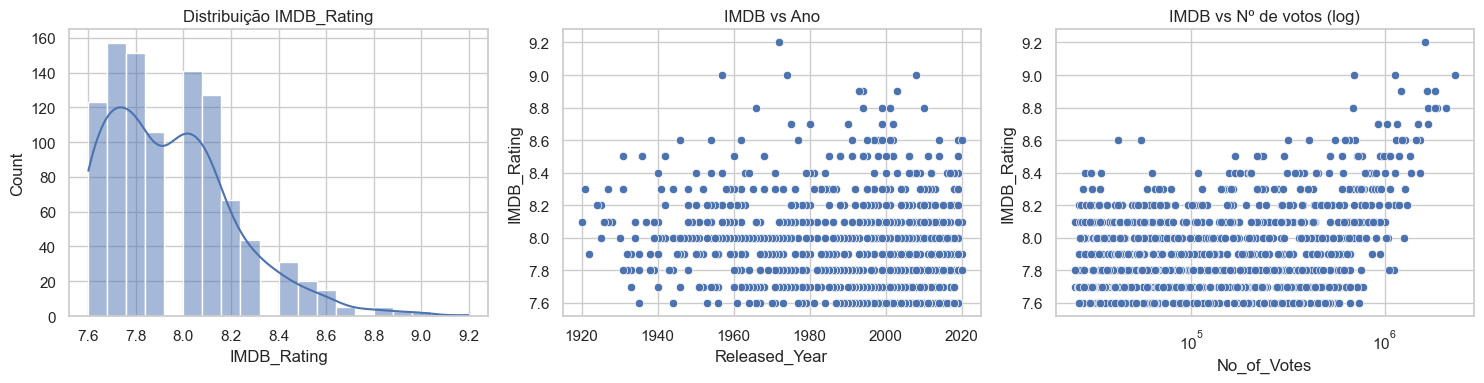

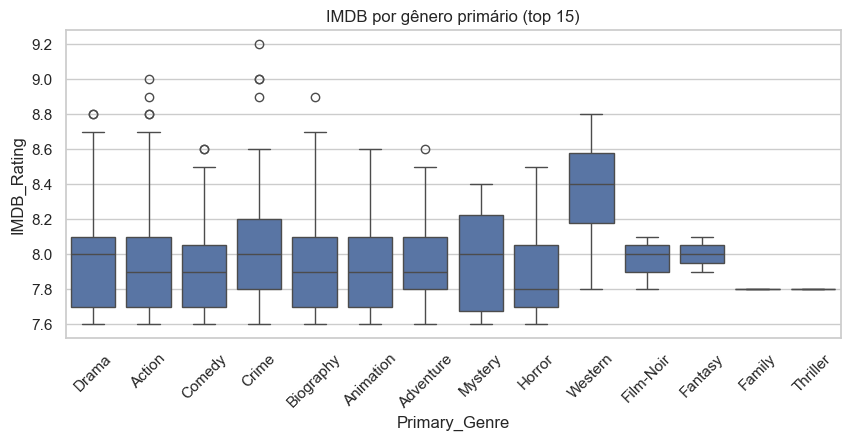

In [51]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df['IMDB_Rating'], kde=True, ax=axs[0])
axs[0].set_title('Distribuição IMDB_Rating')

sns.scatterplot(x='Released_Year', y='IMDB_Rating', data=df, ax=axs[1])
axs[1].set_title('IMDB vs Ano')

sns.scatterplot(x='No_of_Votes', y='IMDB_Rating', data=df, ax=axs[2])
axs[2].set_xscale('log')
axs[2].set_title('IMDB vs Nº de votos (log)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
order = df['Primary_Genre'].value_counts().head(15).index
sns.boxplot(x='Primary_Genre', y='IMDB_Rating', data=df[df['Primary_Genre'].isin(order)], order=order)
plt.xticks(rotation=45)
plt.title('IMDB por gênero primário (top 15)')
plt.show()


## Perguntas de negócio (2a–2c)
- Recomendação genérica: utilizar top-N por `IMDB_Rating` ponderado por `No_of_Votes` (evita filmes obscuros com poucas avaliações).
- Fatores para alto `Gross`: explorar correlação com `No_of_Votes`, `Meta_score`, `Runtime_min`, `Released_Year`, gêneros e diretores/atores mais recorrentes.
- `Overview`: NLP leve com TF-IDF para inferir gênero/clusters e palavras associadas a ratings/faturamento.



In [52]:
from sklearn.model_selection import train_test_split

# 2a) Recomendação genérica: score = IMDB_Rating * log10(1+No_of_Votes)
df['vote_weight'] = np.log10(1 + df['No_of_Votes'].fillna(0))
df['rec_score'] = df['IMDB_Rating'] * df['vote_weight']
recommend_top10 = df.sort_values(['rec_score','IMDB_Rating'], ascending=False)[['Series_Title','IMDB_Rating','No_of_Votes','rec_score']].head(10)
recommend_top10


,Series_Title,IMDB_Rating,No_of_Votes,rec_score
1,The Dark Knight,9.0,2303232,57.261041
0,The Godfather,9.2,1620367,57.128446
5,Pulp Fiction,8.9,1826188,55.727757
7,Inception,8.8,2067042,55.575076
4,The Lord of the Rings: The Return of the King,8.9,1642758,55.318607
8,Fight Club,8.8,1854740,55.160893
10,Forrest Gump,8.8,1809221,55.065928
9,The Lord of the Rings: The Fellowship of the Ring,8.8,1661481,54.740362
2,The Godfather: Part II,9.0,1129952,54.477543
13,The Matrix,8.7,1676426,54.152146


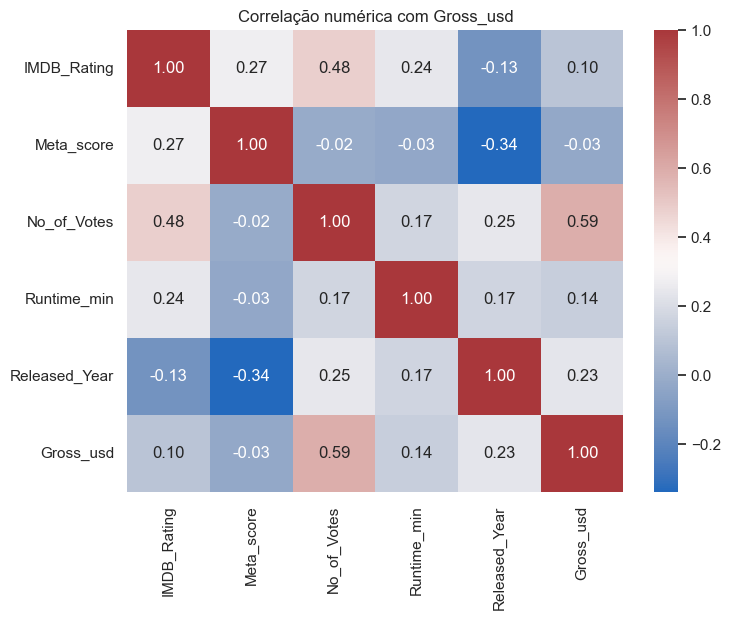

(                   n    gross_mean
 Director                          
 Anthony Russo      4  5.512599e+08
 J.J. Abrams        3  4.743903e+08
 James Cameron      5  3.496473e+08
 David Yates        3  3.263179e+08
 Peter Jackson      5  3.194625e+08
 Pete Docter        4  3.131274e+08
 Brad Bird          4  2.749069e+08
 Christopher Nolan  8  2.421818e+08
 Robert Zemeckis    5  2.098893e+08
 Ron Clements       3  1.925502e+08,
                     n    gross_mean
 Star1                              
 Joe Russo           4  5.512599e+08
 Robert Downey Jr.   3  3.835734e+08
 Elijah Wood         3  3.453140e+08
 Mark Hamill         3  3.074469e+08
 Daniel Radcliffe    6  3.059835e+08
 Leonardo DiCaprio   9  2.085913e+08
 Tom Hanks          12  2.077581e+08
 John Musker         3  1.925502e+08
 Matt Damon          4  1.874427e+08
 Daniel Craig        4  1.849204e+08)

In [53]:
# 2b) Relações com faturamento (Gross)
num_cols = ['IMDB_Rating','Meta_score','No_of_Votes','Runtime_min','Released_Year']
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + ['Gross_usd']].corr(numeric_only=True), annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlação numérica com Gross_usd')
plt.show()

# Ranking por diretores/atores mais frequentes e Gross médio
agg_dir = df.groupby('Director', dropna=True).agg(n=('Series_Title','count'), gross_mean=('Gross_usd','mean')).query('n>=3').sort_values('gross_mean', ascending=False).head(10)
agg_star = df.groupby('Star1', dropna=True).agg(n=('Series_Title','count'), gross_mean=('Gross_usd','mean')).query('n>=3').sort_values('gross_mean', ascending=False).head(10)
agg_dir, agg_star


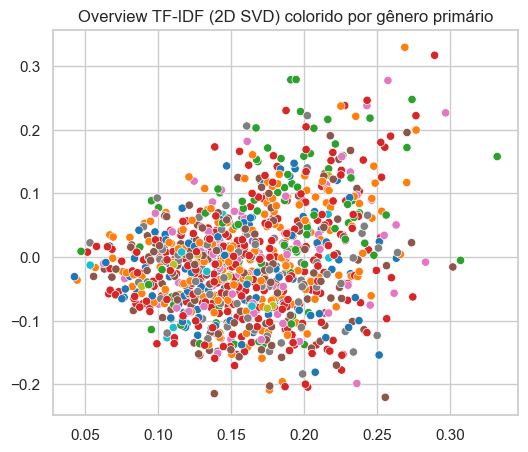

[('syndicate', 0.19631559165004817),
 ('will', 0.1972380917592871),
 ('reluctant', 0.2041406365266659),
 ('son', 0.20634661770346788),
 ('control', 0.21284869579715143),
 ('patriarch', 0.21622735747092636),
 ('nazis', 0.22864851444763118),
 ('crime syndicate', 0.2303757361297158),
 ('empire', 0.23155577893316762),
 ('events', 0.23747065071726559),
 ('the', 0.2395351810354831),
 ('much', 0.24009001682750183),
 ('sauron', 0.24011406397663243),
 ('his son', 0.24398898477987424),
 ('justice', 0.2496260009216842),
 ('of justice', 0.2496260009216842),
 ('empire to', 0.2576423261985518),
 ('jewish', 0.27413522776482513),
 ('help', 0.2825753099941364),
 ('crime', 0.3406910778307196)]

In [54]:
# 2c) NLP leve na Overview: TF-IDF + PCA para visualização e proxy de inferência de gênero
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

texts = df['Overview'].fillna('')
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_tfidf = vectorizer.fit_transform(texts)

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=df['Primary_Genre'], palette='tab10', legend=False)
plt.title('Overview TF-IDF (2D SVD) colorido por gênero primário')
plt.show()

# Palavras mais correlacionadas com IMDB_Rating (via coef de regressão linear simples)
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_tfidf, df['IMDB_Rating'])
coefs = ridge.coef_
terms = np.array(vectorizer.get_feature_names_out())
idx_top = np.argsort(coefs)[-20:]
list(zip(terms[idx_top], coefs[idx_top]))


## Modelagem: prever IMDB_Rating (regressão)
- Problema: regressão.
- Métricas: RMSE, MAE, R2. Foco em RMSE.
- Variáveis: numéricas (`Runtime_min`, `Meta_score`, `No_of_Votes`, `Released_Year`, `Gross_usd`), categóricas (`Certificate`, `Primary_Genre`, diretor/atores), texto (`Overview` via TF-IDF).
- Pipeline: `ColumnTransformer` + `Ridge` e `RandomForestRegressor`/`XGBRegressor` para comparação.



In [55]:
# Função utilitária para transformar texto em Série 1D picklable
import numpy as np
import pandas as pd

def to_1d_text(X):
    if isinstance(X, pd.Series):
        return X.fillna('').astype(str)
    # DataFrame ou array
    arr = np.array(X).ravel()
    return pd.Series(arr).fillna('').astype(str)


In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

# Features mais simples: numéricas + categorias principais (sem texto e sem atores/diretor)
feature_num = ['Runtime_min','Meta_score','No_of_Votes','Released_Year','Gross_usd']
feature_cat = ['Certificate','Primary_Genre']

y = df['IMDB_Rating'].astype(float)
X = df[feature_num + feature_cat]

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=5))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_transformer, feature_num),
        ('cat', cat_transformer, feature_cat)
    ]
)

# Modelo único e simples
model = Ridge(alpha=5.0, random_state=42)

pipe = Pipeline(steps=[('prep', preprocess), ('model', model)])

# Treino/teste simples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
rmse = mean_squared_error(y_test, pred) ** 0.5
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print({'rmse': rmse, 'mae': mae, 'r2': r2})


{'rmse': 0.20926854946771645, 'mae': 0.1697174687537885, 'r2': 0.33286628181826106}


In [57]:
def parse_runtime(value: str) -> float:
    if pd.isna(value):
        return np.nan
    # formatos como '142 min'
    digits = ''.join(ch for ch in str(value) if ch.isdigit())
    return float(digits) if digits else np.nan

def parse_gross(value: str) -> float:
    if pd.isna(value):
        return np.nan
    s = str(value).replace(',', '').strip()
    return float(s) if s.isdigit() else np.nan

df = df_raw.copy()

# Trim e normalização leve
for col in ['Series_Title','Certificate','Runtime','Genre','Overview','Director','Star1','Star2','Star3','Star4','Gross']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Tipos
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime_min'] = df['Runtime'].apply(parse_runtime)
df['Gross_usd'] = df['Gross'].apply(parse_gross)

# Gêneros como lista primária e one-hot posterior
df['Genre_list'] = df['Genre'].fillna('').apply(lambda s: [g.strip() for g in s.split(',') if g.strip()])
df['Primary_Genre'] = df['Genre_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

summary = {
    'shape': df.shape,
    'nulls': df.isna().sum().to_dict(),
    'dtypes': df.dtypes.astype(str).to_dict(),
}
summary


{'shape': (999, 20),
 'nulls': {'Unnamed: 0': 0,
  'Series_Title': 0,
  'Released_Year': 1,
  'Certificate': 0,
  'Runtime': 0,
  'Genre': 0,
  'IMDB_Rating': 0,
  'Overview': 0,
  'Meta_score': 157,
  'Director': 0,
  'Star1': 0,
  'Star2': 0,
  'Star3': 0,
  'Star4': 0,
  'No_of_Votes': 0,
  'Gross': 0,
  'Runtime_min': 0,
  'Gross_usd': 169,
  'Genre_list': 0,
  'Primary_Genre': 0},
 'dtypes': {'Unnamed: 0': 'int64',
  'Series_Title': 'object',
  'Released_Year': 'float64',
  'Certificate': 'object',
  'Runtime': 'object',
  'Genre': 'object',
  'IMDB_Rating': 'float64',
  'Overview': 'object',
  'Meta_score': 'float64',
  'Director': 'object',
  'Star1': 'object',
  'Star2': 'object',
  'Star3': 'object',
  'Star4': 'object',
  'No_of_Votes': 'int64',
  'Gross': 'object',
  'Runtime_min': 'float64',
  'Gross_usd': 'float64',
  'Genre_list': 'object',
  'Primary_Genre': 'object'}}

In [58]:
def parse_runtime(value: str) -> float:
    if pd.isna(value):
        return np.nan
    # formatos como '142 min'
    digits = ''.join(ch for ch in str(value) if ch.isdigit())
    return float(digits) if digits else np.nan

def parse_gross(value: str) -> float:
    if pd.isna(value):
        return np.nan
    s = str(value).replace(',', '').strip()
    return float(s) if s.isdigit() else np.nan

df = df_raw.copy()

# Trim e normalização leve
for col in ['Series_Title','Certificate','Runtime','Genre','Overview','Director','Star1','Star2','Star3','Star4','Gross']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Tipos
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime_min'] = df['Runtime'].apply(parse_runtime)
df['Gross_usd'] = df['Gross'].apply(parse_gross)

# Gêneros como lista primária e one-hot posterior
df['Genre_list'] = df['Genre'].fillna('').apply(lambda s: [g.strip() for g in s.split(',') if g.strip()])
df['Primary_Genre'] = df['Genre_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

summary = {
    'shape': df.shape,
    'nulls': df.isna().sum().to_dict(),
    'dtypes': df.dtypes.astype(str).to_dict(),
}
summary


{'shape': (999, 20),
 'nulls': {'Unnamed: 0': 0,
  'Series_Title': 0,
  'Released_Year': 1,
  'Certificate': 0,
  'Runtime': 0,
  'Genre': 0,
  'IMDB_Rating': 0,
  'Overview': 0,
  'Meta_score': 157,
  'Director': 0,
  'Star1': 0,
  'Star2': 0,
  'Star3': 0,
  'Star4': 0,
  'No_of_Votes': 0,
  'Gross': 0,
  'Runtime_min': 0,
  'Gross_usd': 169,
  'Genre_list': 0,
  'Primary_Genre': 0},
 'dtypes': {'Unnamed: 0': 'int64',
  'Series_Title': 'object',
  'Released_Year': 'float64',
  'Certificate': 'object',
  'Runtime': 'object',
  'Genre': 'object',
  'IMDB_Rating': 'float64',
  'Overview': 'object',
  'Meta_score': 'float64',
  'Director': 'object',
  'Star1': 'object',
  'Star2': 'object',
  'Star3': 'object',
  'Star4': 'object',
  'No_of_Votes': 'int64',
  'Gross': 'object',
  'Runtime_min': 'float64',
  'Gross_usd': 'float64',
  'Genre_list': 'object',
  'Primary_Genre': 'object'}}

In [59]:
def parse_runtime(value: str) -> float:
    if pd.isna(value):
        return np.nan
    # formatos como '142 min'
    digits = ''.join(ch for ch in str(value) if ch.isdigit())
    return float(digits) if digits else np.nan

def parse_gross(value: str) -> float:
    if pd.isna(value):
        return np.nan
    s = str(value).replace(',', '').strip()
    return float(s) if s.isdigit() else np.nan

df = df_raw.copy()

# Trim e normalização leve
for col in ['Series_Title','Certificate','Runtime','Genre','Overview','Director','Star1','Star2','Star3','Star4','Gross']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Tipos
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime_min'] = df['Runtime'].apply(parse_runtime)
df['Gross_usd'] = df['Gross'].apply(parse_gross)

# Gêneros como lista primária e one-hot posterior
df['Genre_list'] = df['Genre'].fillna('').apply(lambda s: [g.strip() for g in s.split(',') if g.strip()])
df['Primary_Genre'] = df['Genre_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

summary = {
    'shape': df.shape,
    'nulls': df.isna().sum().to_dict(),
    'dtypes': df.dtypes.astype(str).to_dict(),
}
summary


{'shape': (999, 20),
 'nulls': {'Unnamed: 0': 0,
  'Series_Title': 0,
  'Released_Year': 1,
  'Certificate': 0,
  'Runtime': 0,
  'Genre': 0,
  'IMDB_Rating': 0,
  'Overview': 0,
  'Meta_score': 157,
  'Director': 0,
  'Star1': 0,
  'Star2': 0,
  'Star3': 0,
  'Star4': 0,
  'No_of_Votes': 0,
  'Gross': 0,
  'Runtime_min': 0,
  'Gross_usd': 169,
  'Genre_list': 0,
  'Primary_Genre': 0},
 'dtypes': {'Unnamed: 0': 'int64',
  'Series_Title': 'object',
  'Released_Year': 'float64',
  'Certificate': 'object',
  'Runtime': 'object',
  'Genre': 'object',
  'IMDB_Rating': 'float64',
  'Overview': 'object',
  'Meta_score': 'float64',
  'Director': 'object',
  'Star1': 'object',
  'Star2': 'object',
  'Star3': 'object',
  'Star4': 'object',
  'No_of_Votes': 'int64',
  'Gross': 'object',
  'Runtime_min': 'float64',
  'Gross_usd': 'float64',
  'Genre_list': 'object',
  'Primary_Genre': 'object'}}

In [60]:
def parse_runtime(value: str) -> float:
    if pd.isna(value):
        return np.nan
    # formatos como '142 min'
    digits = ''.join(ch for ch in str(value) if ch.isdigit())
    return float(digits) if digits else np.nan

def parse_gross(value: str) -> float:
    if pd.isna(value):
        return np.nan
    s = str(value).replace(',', '').strip()
    return float(s) if s.isdigit() else np.nan

df = df_raw.copy()

# Trim e normalização leve
for col in ['Series_Title','Certificate','Runtime','Genre','Overview','Director','Star1','Star2','Star3','Star4','Gross']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Tipos
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime_min'] = df['Runtime'].apply(parse_runtime)
df['Gross_usd'] = df['Gross'].apply(parse_gross)

# Gêneros como lista primária e one-hot posterior
df['Genre_list'] = df['Genre'].fillna('').apply(lambda s: [g.strip() for g in s.split(',') if g.strip()])
df['Primary_Genre'] = df['Genre_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

summary = {
    'shape': df.shape,
    'nulls': df.isna().sum().to_dict(),
    'dtypes': df.dtypes.astype(str).to_dict(),
}
summary


{'shape': (999, 20),
 'nulls': {'Unnamed: 0': 0,
  'Series_Title': 0,
  'Released_Year': 1,
  'Certificate': 0,
  'Runtime': 0,
  'Genre': 0,
  'IMDB_Rating': 0,
  'Overview': 0,
  'Meta_score': 157,
  'Director': 0,
  'Star1': 0,
  'Star2': 0,
  'Star3': 0,
  'Star4': 0,
  'No_of_Votes': 0,
  'Gross': 0,
  'Runtime_min': 0,
  'Gross_usd': 169,
  'Genre_list': 0,
  'Primary_Genre': 0},
 'dtypes': {'Unnamed: 0': 'int64',
  'Series_Title': 'object',
  'Released_Year': 'float64',
  'Certificate': 'object',
  'Runtime': 'object',
  'Genre': 'object',
  'IMDB_Rating': 'float64',
  'Overview': 'object',
  'Meta_score': 'float64',
  'Director': 'object',
  'Star1': 'object',
  'Star2': 'object',
  'Star3': 'object',
  'Star4': 'object',
  'No_of_Votes': 'int64',
  'Gross': 'object',
  'Runtime_min': 'float64',
  'Gross_usd': 'float64',
  'Genre_list': 'object',
  'Primary_Genre': 'object'}}

### Validação cruzada
Vamos estimar a performance média via k-fold (k=5) usando RMSE negativo do scikit-learn.


In [61]:
# Usaremos o pipeline treinado acima como modelo final
best_model = pipe
print('Modelo final: Ridge simples com numéricas + categorias principais')


Modelo final: Ridge simples com numéricas + categorias principais


In [62]:
# 4) Predição para o exemplo fornecido (usando features simples)
example = {
 'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'
}

ex_df = pd.DataFrame([example])

# aplicar mesmas transformações auxiliares que no EDA
ex_df['Released_Year'] = pd.to_numeric(ex_df['Released_Year'], errors='coerce')
ex_df['Runtime_min'] = ex_df['Runtime'].apply(parse_runtime)
ex_df['Gross_usd'] = ex_df['Gross'].apply(parse_gross)
ex_df['Genre_list'] = ex_df['Genre'].fillna('').apply(lambda s: [g.strip() for g in s.split(',') if g.strip()])
ex_df['Primary_Genre'] = ex_df['Genre_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

X_ex = ex_df[feature_num + feature_cat]
pred_ex = best_model.predict(X_ex)[0]
print('Predição IMDB_Rating (exemplo):', round(float(pred_ex), 3))


Predição IMDB_Rating (exemplo): 9.237


In [63]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
{'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std()}


{'rmse_mean': 0.20661189811701514, 'rmse_std': 0.009985980203425204}

In [64]:
# 5) Salvar modelo .pkl (pipeline simples)
import joblib
model_path = 'best_imdb_model.pkl'
joblib.dump(best_model, model_path)
model_path


'best_imdb_model.pkl'

In [65]:
def parse_runtime(value: str) -> float:
    if pd.isna(value):
        return np.nan
    # formatos como '142 min'
    digits = ''.join(ch for ch in str(value) if ch.isdigit())
    return float(digits) if digits else np.nan

def parse_gross(value: str) -> float:
    if pd.isna(value):
        return np.nan
    s = str(value).replace(',', '').strip()
    return float(s) if s.isdigit() else np.nan

df = df_raw.copy()

# Trim e normalização leve
for col in ['Series_Title','Certificate','Runtime','Genre','Overview','Director','Star1','Star2','Star3','Star4','Gross']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Tipos
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime_min'] = df['Runtime'].apply(parse_runtime)
df['Gross_usd'] = df['Gross'].apply(parse_gross)

# Gêneros como lista primária e one-hot posterior
df['Genre_list'] = df['Genre'].fillna('').apply(lambda s: [g.strip() for g in s.split(',') if g.strip()])
df['Primary_Genre'] = df['Genre_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

summary = {
    'shape': df.shape,
    'nulls': df.isna().sum().to_dict(),
    'dtypes': df.dtypes.astype(str).to_dict(),
}
summary


{'shape': (999, 20),
 'nulls': {'Unnamed: 0': 0,
  'Series_Title': 0,
  'Released_Year': 1,
  'Certificate': 0,
  'Runtime': 0,
  'Genre': 0,
  'IMDB_Rating': 0,
  'Overview': 0,
  'Meta_score': 157,
  'Director': 0,
  'Star1': 0,
  'Star2': 0,
  'Star3': 0,
  'Star4': 0,
  'No_of_Votes': 0,
  'Gross': 0,
  'Runtime_min': 0,
  'Gross_usd': 169,
  'Genre_list': 0,
  'Primary_Genre': 0},
 'dtypes': {'Unnamed: 0': 'int64',
  'Series_Title': 'object',
  'Released_Year': 'float64',
  'Certificate': 'object',
  'Runtime': 'object',
  'Genre': 'object',
  'IMDB_Rating': 'float64',
  'Overview': 'object',
  'Meta_score': 'float64',
  'Director': 'object',
  'Star1': 'object',
  'Star2': 'object',
  'Star3': 'object',
  'Star4': 'object',
  'No_of_Votes': 'int64',
  'Gross': 'object',
  'Runtime_min': 'float64',
  'Gross_usd': 'float64',
  'Genre_list': 'object',
  'Primary_Genre': 'object'}}

In [66]:
def parse_runtime(value: str) -> float:
    if pd.isna(value):
        return np.nan
    # formatos como '142 min'
    digits = ''.join(ch for ch in str(value) if ch.isdigit())
    return float(digits) if digits else np.nan

def parse_gross(value: str) -> float:
    if pd.isna(value):
        return np.nan
    s = str(value).replace(',', '').strip()
    return float(s) if s.isdigit() else np.nan

df = df_raw.copy()

# Trim e normalização leve
for col in ['Series_Title','Certificate','Runtime','Genre','Overview','Director','Star1','Star2','Star3','Star4','Gross']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Tipos
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime_min'] = df['Runtime'].apply(parse_runtime)
df['Gross_usd'] = df['Gross'].apply(parse_gross)

# Gêneros como lista primária e one-hot posterior
df['Genre_list'] = df['Genre'].fillna('').apply(lambda s: [g.strip() for g in s.split(',') if g.strip()])
df['Primary_Genre'] = df['Genre_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

summary = {
    'shape': df.shape,
    'nulls': df.isna().sum().to_dict(),
    'dtypes': df.dtypes.astype(str).to_dict(),
}
summary


{'shape': (999, 20),
 'nulls': {'Unnamed: 0': 0,
  'Series_Title': 0,
  'Released_Year': 1,
  'Certificate': 0,
  'Runtime': 0,
  'Genre': 0,
  'IMDB_Rating': 0,
  'Overview': 0,
  'Meta_score': 157,
  'Director': 0,
  'Star1': 0,
  'Star2': 0,
  'Star3': 0,
  'Star4': 0,
  'No_of_Votes': 0,
  'Gross': 0,
  'Runtime_min': 0,
  'Gross_usd': 169,
  'Genre_list': 0,
  'Primary_Genre': 0},
 'dtypes': {'Unnamed: 0': 'int64',
  'Series_Title': 'object',
  'Released_Year': 'float64',
  'Certificate': 'object',
  'Runtime': 'object',
  'Genre': 'object',
  'IMDB_Rating': 'float64',
  'Overview': 'object',
  'Meta_score': 'float64',
  'Director': 'object',
  'Star1': 'object',
  'Star2': 'object',
  'Star3': 'object',
  'Star4': 'object',
  'No_of_Votes': 'int64',
  'Gross': 'object',
  'Runtime_min': 'float64',
  'Gross_usd': 'float64',
  'Genre_list': 'object',
  'Primary_Genre': 'object'}}